<a href="https://colab.research.google.com/github/aban94/DeepLearning_CSE676/blob/main/VoxelMorph_AUC_M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!git clone https://github.com/voxelmorph/voxelmorph.git

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Deep Learning Project/Voxelmorph/voxelmorph/voxelmorph/py

/content/drive/MyDrive/Deep Learning Project/Voxelmorph/voxelmorph/voxelmorph/py


In [ ]:
#!ls

In [ ]:
!pip install voxelmorph

In [ ]:
#!/usr/bin/env python

"""
Example script to train a VoxelMorph model.
You will likely have to customize this script slightly to accommodate your own data. All images
should be appropriately cropped and scaled to values between 0 and 1.
If an atlas file is provided with the --atlas flag, then scan-to-atlas training is performed.
Otherwise, registration will be scan-to-scan.
If you use this code, please cite the following, and read function docs for further info/citations.
    VoxelMorph: A Learning Framework for Deformable Medical Image Registration G. Balakrishnan, A.
    Zhao, M. R. Sabuncu, J. Guttag, A.V. Dalca. IEEE TMI: Transactions on Medical Imaging. 38(8). pp
    1788-1800. 2019. 
    or
    Unsupervised Learning for Probabilistic Diffeomorphic Registration for Images and Surfaces
    A.V. Dalca, G. Balakrishnan, J. Guttag, M.R. Sabuncu. 
    MedIA: Medical Image Analysis. (57). pp 226-236, 2019 
Copyright 2020 Adrian V. Dalca
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in
compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is
distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
implied. See the License for the specific language governing permissions and limitations under the
License.
"""

import os
import random
import argparse
import time
import numpy as np
import torch
import copy

# import voxelmorph with pytorch backend
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm  # nopep8
import torchvision
import torchvision.datasets as datasets
from IPython import embed
import neurite as ne
import utils

In [ ]:

class args():
  load_model=False
  atlas = False
  gpu = 0
  batch_size = 1
  bidir = False
  multichannel = False
  image_loss = 'mse'
  lr = 0.001
  int_downsize = 1
  weight = 0.01
  epochs = 1
  steps_per_epoch = 5
  

bidir = args.bidir


#Loading and readying dataset

In [ ]:
import cv2

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [ ]:

def get_5(dataset):
  c_dataset = copy.deepcopy(dataset)
  idx = c_dataset.targets==5
  c_dataset.targets = c_dataset.targets[idx]
  c_dataset.data = c_dataset.data[idx]
  return c_dataset
mnist_trainset_5 = get_5(mnist_trainset)
mnist_testset_5 = get_5(mnist_testset)
x_train, y_train, x_test, y_test = mnist_trainset_5.data, mnist_trainset_5.targets, mnist_testset_5.data, mnist_testset_5.targets
x_train = x_train.numpy()
y_train = y_train.numpy()
x_test = x_test.numpy()
y_test = y_test.numpy()



In [ ]:
im_num=0
file_list = ""
for img in x_test[:100]:
  im_num +=1
  file_list += "/content/images_100/{}.jpg\n/content/images_100/moved_image.jpg\n".format(im_num)
  cv2.imwrite('/content/images_100/{}.jpg'.format(im_num),img)


In [ ]:
# file_list
f = open("img_list.txt", "a")
f.write(file_list)
f.close()

In [ ]:
#getting val set from train set
nb_val = 1000  # keep 1,000 subjects for validation
x_val = x_train[-nb_val:, ...]  # this indexing means "the last nb_val entries" of the zeroth axis
y_val = y_train[-nb_val:]
x_train = x_train[:-nb_val, ...]
y_train = y_train[:-nb_val]

In [ ]:
x_train.shape,y_train.shape,x_val.shape,y_val.shape,x_test.shape,y_test.shape

((4421, 28, 28), (4421,), (1000, 28, 28), (1000,), (892, 28, 28), (892,))

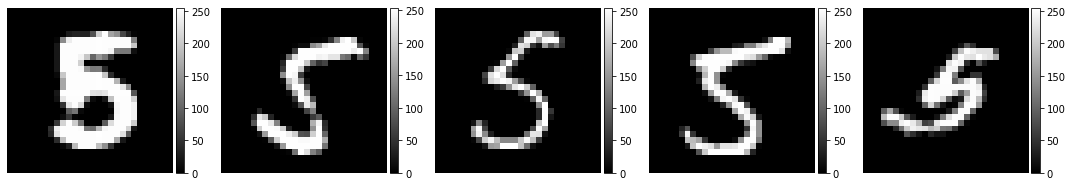

In [ ]:
nb_vis = 5

# choose nb_vis sample indexes
idx = np.random.choice(x_train.shape[0], nb_vis, replace=False)
example_digits = [f for f in x_train[idx, ...]]

# plot
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [ ]:
# fix data
x_train = x_train.astype('float')/255
x_val = x_val.astype('float')/255
x_test = x_test.astype('float')/255

# verify
print('training maximum value', x_train.max())

training maximum value 1.0


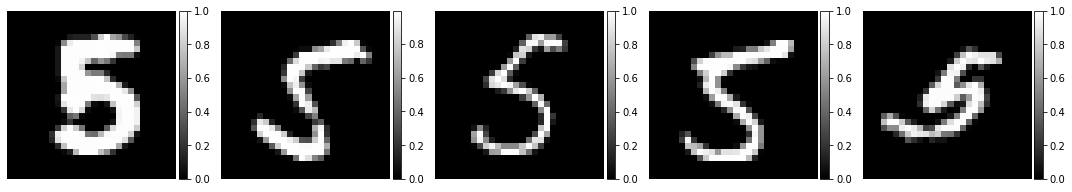

In [ ]:
# re-visualize
example_digits = [f for f in x_train[idx, ...]]
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [ ]:
pad_amount = ((0, 0), (2,2), (2,2))

# fix data
x_train = np.pad(x_train, pad_amount, 'constant')
x_val = np.pad(x_val, pad_amount, 'constant')
x_test = np.pad(x_test, pad_amount, 'constant')

# verify
print('shape of training data', x_train.shape)

shape of training data (4421, 32, 32)


#CNN Model



In [ ]:
import torch
import torch.nn as nn

In [ ]:
# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
inshape = (*x_train.shape[1:], unet_input_features)

# configure unet features 
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]
enc_nf=[32, 32, 32, 32]
dec_nf=[32, 32, 32, 32, 32, 16]

# # build model
unet = vxm.networks.Unet(inshape=inshape, nb_features=nb_features)


In [ ]:
unet

Unet(
  (upsample): Upsample(scale_factor=2.0, mode=nearest)
  (downarm): ModuleList(
    (0): ConvBlock(
      (main): Conv3d(2, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (1): ConvBlock(
      (main): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (2): ConvBlock(
      (main): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (3): ConvBlock(
      (main): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
  )
  (uparm): ModuleList(
    (0): ConvBlock(
      (main): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (1): ConvBlock(
      (main): Conv3d(64, 32, kernel_size=(3

In [ ]:
# print('input shape: ', unet.input.shape)
# print('output shape:', unet.output.shape)
input_shape = (None, 32, 32, 2)
output_shape = (None,32,32,16)


In [ ]:
# transform the results into a flow field.
# disp_tensor = tf.keras.layers.Conv2D(ndim, kernel_size=3, padding='same', name='disp')(unet.output)
disp_tensor = nn.Conv2d(32*32, ndim, kernel_size=3, stride=1, padding='same')
# check tensor shape
# print('displacement tensor:', disp_tensor.shape)
print(disp_tensor)
# using keras, we can easily form new models via tensor pointers
# def_model = tf.keras.models.Model(unet.inputs, disp_tensor)

Conv2d(1024, 2, kernel_size=(3, 3), stride=(1, 1), padding=same)


In [ ]:
# vxm.layers.SpatialTransformer()

In [ ]:
# model = vxm.networks.VxmDense(
#     inshape=inshape,
#     nb_unet_features=nb_features,
#     bidir=args.bidir
    
# )


In [ ]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
# load and prepare training data
train_files = utils.read_file_list("/content/drive/MyDrive/Deep Learning Project/Voxelmorph/npz.txt")
# assert len(train_files) > 0, 'Could not find any training data.'

# no need to append an extra feature axis if data is multichannel
add_feat_axis = not args.multichannel

# if args.atlas:
#     # scan-to-atlas generator
#     atlas = vxm.py.utils.load_volfile(args.atlas, np_var='vol',
#                                       add_batch_axis=True, add_feat_axis=add_feat_axis)
#     generator = vxm.generators.scan_to_atlas(train_files, atlas,
#                                              batch_size=args.batch_size, bidir=args.bidir,
#                                              add_feat_axis=add_feat_axis)
# else:
    # scan-to-scan generator
generator = vxm.generators.scan_to_scan(
    train_files, batch_size=args.batch_size, bidir=args.bidir, add_feat_axis=add_feat_axis)

# embed()
# # extract shape from sampled input
inshape = next(generator)[0][0].shape[1:-1]

# prepare model folder
# model_dir = args.model_dir
# os.makedirs(model_dir, exist_ok=True)

# # device handling
# gpus = args.gpu.split(',')
# nb_gpus = len(gpus)
device = 'cuda:0'
# os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
# assert np.mod(args.batch_size, nb_gpus) == 0, \
#     'Batch size (%d) should be a multiple of the nr of gpus (%d)' % (args.batch_size, nb_devices)

# # enabling cudnn determinism appears to speed up training by a lot
# torch.backends.cudnn.deterministic = not args.cudnn_nondet

# # unet architecture
#enc_nf = args.enc if args.enc else [16, 32, 32, 32]
# enc_nf = [16, 32, 32, 32]
#dec_nf = args.dec if args.dec else [32, 32, 32, 32, 32, 16, 16]
# dec_nf = [32, 32, 32, 32, 32, 16, 16]

# if args.load_model:
#     # load initial model (if specified)
#     model = vxm.networks.VxmDense.load(args.load_model, device)
# else:
    # otherwise configure new model
model = vxm.networks.VxmDense(inshape=inshape,nb_unet_features=[enc_nf, dec_nf],bidir=bidir,int_downsize=args.int_downsize)

# if nb_gpus > 1:
#     # use multiple GPUs via DataParallel
#     model = torch.nn.DataParallel(model)
#     model.save = model.module.save

# prepare the model for training and send to device
model.to(device)
model.train()
best_val_auc=0
# set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

# prepare image loss
if args.image_loss == 'ncc':
    image_loss_func = vxm.losses.NCC().loss
elif args.image_loss == 'mse':
    image_loss_func = vxm.losses.MSE().loss
else:
    raise ValueError('Image loss should be "mse" or "ncc", but found "%s"' % args.image_loss)

# need two image loss functions if bidirectional
if bidir:
    losses = [image_loss_func, image_loss_func]
    weights = [0.5, 0.5]
else:
    losses = [image_loss_func]
    weights = [1]

# prepare deformation loss
losses += [vxm.losses.Grad('l2', loss_mult=args.int_downsize).loss]
weights += [args.weight]

# training loops
for epoch in range(2):

    # save model checkpoint
    # if epoch % 20 == 0:
    #     model.save(os.path.join(model_dir, '%04d.pt' % epoch))

    epoch_loss = []
    epoch_total_loss = []
    epoch_step_time = []

    for step in range(10):

        step_start_time = time.time()

        # generate inputs (and true outputs) and convert them to tensors
        inputs, y_true = next(generator)
        inputs = [torch.from_numpy(d).to(device).float().permute(0, 4, 1, 2, 3) for d in inputs]
        y_true = [torch.from_numpy(d).to(device).float().permute(0, 4, 1, 2, 3) for d in y_true]
        print(len(inputs),len(y_true),inputs[0].shape)
        # run inputs through the model to produce a warped image and flow field
        # y_pred = []
        # for input in inputs:

        #     y_pred_case = model(input)
        #     y_pred.append(y_pred_case)
        print(y_true[0].shape)
        y_pred = model(*inputs)
        y_true_0 = y_true[0].detach().cpu().numpy().squeeze()
        #y_true_1 = y_true[1].detach().cpu().numpy().squeeze()
        y_pred_0 = y_pred[0].detach().cpu().numpy().squeeze()
        y_true_0 = y_true_0.ravel()
        y_pred_0 = y_pred_0.ravel()
        # print(y_true_0.shape)
        # print(y_pred_0.shape)
        # y_true_mean = np.mean(y_true_0)
        # y_pred_mean = np.mean(y_pred_0)
        for idx in range(len(y_true_0)):
            if(y_true_0[idx]!=0):
                y_true_0[idx]=1
            # else:
            #     y_true_0[idx]=0
            if(y_pred_0[idx]!=0):
                y_pred_0[idx]=1
            # else:
            #     y_pred_0[idx]=0
       
        val_auc_mean = roc_auc_score(y_true_0, y_pred_0) 
        if(val_auc_mean>best_val_auc):
            best_val_auc=val_auc_mean
            torch.save(model.state_dict(), '/content/drive/MyDrive/Deep Learning Project/Voxelmorph/ce_pretrained_model.pth')
        #print(val_auc_mean)

        # calculate total loss
        loss = 0
        loss_list = []
        for n, loss_function in enumerate(losses):
            curr_loss = loss_function(y_true[n], y_pred[n]) * weights[n]
            loss_list.append(curr_loss.item())
            loss += curr_loss

        epoch_loss.append(loss_list)
        epoch_total_loss.append(loss.item())

        # backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # get compute time
        epoch_step_time.append(time.time() - step_start_time)
        print ('Steps=%s, Val_AUC=%.4f, Best_Val_AUC=%.4f'%(step, val_auc_mean, best_val_auc ))

    # print epoch info
    epoch_info = 'Epoch %d/%d' % (epoch + 1, args.epochs)
    time_info = '%.4f sec/step' % np.mean(epoch_step_time)
    losses_info = ', '.join(['%.4e' % f for f in np.mean(epoch_loss, axis=0)])
    loss_info = 'loss: %.4e  (%s)' % (np.mean(epoch_total_loss), losses_info)
    #print(' - '.join((epoch_info, time_info, loss_info)), flush=True)
    print ('Epoch=%s, Val_AUC=%.4f, Best_Val_AUC=%.4f'%(epoch, val_auc_mean, best_val_auc ))



2 2 torch.Size([1, 1, 128, 32, 32])
torch.Size([1, 1, 128, 32, 32])
Steps=0, Val_AUC=0.8022, Best_Val_AUC=0.8022
2 2 torch.Size([1, 1, 128, 32, 32])
torch.Size([1, 1, 128, 32, 32])
Steps=1, Val_AUC=0.7319, Best_Val_AUC=0.8022
2 2 torch.Size([1, 1, 128, 32, 32])
torch.Size([1, 1, 128, 32, 32])
Steps=2, Val_AUC=0.7217, Best_Val_AUC=0.8022
2 2 torch.Size([1, 1, 128, 32, 32])
torch.Size([1, 1, 128, 32, 32])
Steps=3, Val_AUC=0.7236, Best_Val_AUC=0.8022
2 2 torch.Size([1, 1, 128, 32, 32])
torch.Size([1, 1, 128, 32, 32])
Steps=4, Val_AUC=0.7245, Best_Val_AUC=0.8022
2 2 torch.Size([1, 1, 128, 32, 32])
torch.Size([1, 1, 128, 32, 32])
Steps=5, Val_AUC=0.7213, Best_Val_AUC=0.8022
2 2 torch.Size([1, 1, 128, 32, 32])
torch.Size([1, 1, 128, 32, 32])
Steps=6, Val_AUC=0.7239, Best_Val_AUC=0.8022
2 2 torch.Size([1, 1, 128, 32, 32])
torch.Size([1, 1, 128, 32, 32])
Steps=7, Val_AUC=0.7244, Best_Val_AUC=0.8022
2 2 torch.Size([1, 1, 128, 32, 32])
torch.Size([1, 1, 128, 32, 32])
Steps=8, Val_AUC=0.7244, Bes

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#model = vxm.networks.VxmDense(inshape=inshape,nb_unet_features=[enc_nf, dec_nf],bidir=bidir,int_downsize=args.int_downsize)

In [ ]:
# # load pretrained model
# if True:
#   PATH = '/content/drive/MyDrive/Deep Learning Project/Voxelmorph/ce_pretrained_model.pth' 
#   state_dict = torch.load(PATH)
#   state_dict.pop('classifier.weight', None)
#   state_dict.pop('classifier.bias', None) 
#   model.load_state_dict(state_dict, strict=False)

In [ ]:
!pip install libauc

In [ ]:
from libauc.losses import AUCMLoss, CrossEntropyLoss
from libauc.optimizers import PESG, Adam

In [ ]:
Loss = AUCMLoss(imratio=0.01)
optimizer = PESG(model, 
                 a=Loss.a, 
                 b=Loss.b, 
                 alpha=Loss.alpha,
                 imratio = 0.01, 
                 lr=args.lr,
                 weight_decay=args.weight)


In [ ]:
#from itertools import Predicate
# load and prepare training data
train_files = utils.read_file_list("/content/drive/MyDrive/Deep Learning Project/Voxelmorph/npz.txt")
# assert len(train_files) > 0, 'Could not find any training data.'

# no need to append an extra feature axis if data is multichannel
add_feat_axis = not args.multichannel


generator = vxm.generators.scan_to_scan(
    train_files, batch_size=args.batch_size, bidir=args.bidir, add_feat_axis=add_feat_axis)

# embed()
# # extract shape from sampled input
inshape = next(generator)[0][0].shape[1:-1]


device = 'cuda:0'

model = vxm.networks.VxmDense(inshape=inshape,nb_unet_features=[enc_nf, dec_nf],bidir=bidir,int_downsize=args.int_downsize)


model.to(device)
model.train()
best_val_auc=0
# set optimizer
optimizer = optimizer
image_loss_func = Loss

# prepare image loss
# if args.image_loss == 'ncc':
#     image_loss_func = vxm.losses.NCC().loss
# elif args.image_loss == 'mse':
#     image_loss_func = vxm.losses.MSE().loss
# else:
#     raise ValueError('Image loss should be "mse" or "ncc", but found "%s"' % args.image_loss)

# need two image loss functions if bidirectional
if bidir:
    losses = [image_loss_func, image_loss_func]
    weights = [0.5, 0.5]
else:
    losses = [image_loss_func]
    weights = [1]
auc_threshold = 0.2

# prepare deformation loss
# losses += [vxm.losses.Grad('l2', loss_mult=args.int_downsize).loss]
# weights += [args.weight]

# training loops
for epoch in range(5):

    # save model checkpoint
    # if epoch % 20 == 0:
    #     model.save(os.path.join(model_dir, '%04d.pt' % epoch))
    if epoch > 0:
      optimizer.update_regularizer(decay_factor=10)
    epoch_loss = []
    epoch_total_loss = []
    epoch_step_time = []

    for step in range(10):

        step_start_time = time.time()

        # generate inputs (and true outputs) and convert them to tensors
        inputs, y_true = next(generator)
        inputs = [torch.from_numpy(d).to(device).float().permute(0, 4, 1, 2, 3) for d in inputs]
        y_true = [torch.from_numpy(d).to(device).float().permute(0, 4, 1, 2, 3) for d in y_true]
        print(len(inputs),len(y_true),inputs[0].shape)
        # run inputs through the model to produce a warped image and flow field
        # y_pred = []
        # for input in inputs:

        #     y_pred_case = model(input)
        #     y_pred.append(y_pred_case)
        print(y_true[0].shape)
        y_pred = model(*inputs)
        y_true_0 = y_true[0].detach().cpu().numpy().squeeze()
        #y_true_1 = y_true[1].detach().cpu().numpy().squeeze()
        y_pred_0 = y_pred[0].detach().cpu().numpy().squeeze()
        y_true_0 = y_true_0.ravel()
        y_pred_0 = y_pred_0.ravel()
        # print(y_true_0.shape)
        # print(y_pred_0.shape)
        # y_true_median = np.median(y_true_0)
        # y_pred_median = np.median(y_pred_0)
        # for idx in range(len(y_true_0)):
        #     if(y_true_0[idx]!=0):
        #         y_true_0[idx]=1
        #     # else:
        #     #     y_true_0[idx]=0
        #     if(y_pred_0[idx]!=0):
        #         y_pred_0[idx]=1
        #auc_threshold = np.mean(np.abs(y_true_0-y_pred_0))
        predictions = np.zeros(y_pred_0.shape)
        for idx in range(len(y_true_0)):
            if(np.abs(y_true_0[idx]-y_pred_0[idx])<auc_threshold):
                predictions[idx] = 1.0
                 #y_true_0[idx]=1
            # # else:
            # #     y_true_0[idx]=0
            # if(y_pred_0[idx]!=0):
            #     y_pred_0[idx]=1
            # # else:
            # #     y_pred_0[idx]=0
        truth = np.ones(y_pred_0.shape)
        val_auc_mean = roc_auc_score(y_true_0, predictions) 
        if(val_auc_mean>best_val_auc):
            best_val_auc=val_auc_mean
        #print(val_auc_mean)

        # calculate total loss
        loss = 0
        loss_list = []
        for n, loss_function in enumerate(losses):
          #loss_function = image_loss_func
          curr_loss = loss_function(y_true[n], y_pred[n]) * weights[n]
          loss_list.append(curr_loss.item())
          loss += curr_loss

        epoch_loss.append(loss_list)
        epoch_total_loss.append(loss.item())

        # backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # get compute time
        epoch_step_time.append(time.time() - step_start_time)
        #print("step:{}".format(step))
        print ('Step=%s, Val_AUC=%.4f, Best_Val_AUC=%.4f'%(step, val_auc_mean, best_val_auc ))
        torch.cuda.empty_cache()

    # print epoch info
    epoch_info = 'Epoch %d/%d' % (epoch + 1, args.epochs)
    time_info = '%.4f sec/step' % np.mean(epoch_step_time)
    losses_info = ', '.join(['%.4e' % f for f in np.mean(epoch_loss, axis=0)])
    loss_info = 'loss: %.4e  (%s)' % (np.mean(epoch_total_loss), losses_info)
    #print(' - '.join((epoch_info, time_info, loss_info)), flush=True)
    print ('Epoch=%s, Val_AUC=%.4f, Best_Val_AUC=%.4f'%(epoch, val_auc_mean, best_val_auc ))
    #gc.collect()
    torch.cuda.empty_cache()



2 2 torch.Size([1, 1, 128, 32, 32])
torch.Size([1, 1, 128, 32, 32])


ValueError: ignored

In [ ]:
pred = np.zeros(y_pred_0.shape)

In [ ]:
print(len(y_true))
print(y_true[0].shape)
print(len(y_pred))
print(y_pred[0].shape)

2
torch.Size([1, 1, 160, 192, 224])
2
torch.Size([1, 1, 160, 192, 224])


In [ ]:
y_true_0 = y_true[0].detach().cpu().numpy().squeeze()
y_true_1 = y_true[1].detach().cpu().numpy().squeeze()
y_pred_0 = y_pred[0].detach().cpu().numpy().squeeze()
y_pred_1 = y_pred[1].detach().cpu().numpy().squeeze()
print(y_true_0.shape, y_true_1.shape, y_pred_0.shape, y_pred_1.shape)

(160, 192, 224) (3, 160, 192, 224) (160, 192, 224) (3, 160, 192, 224)


In [ ]:
y_true_0 = y_true_0.ravel()
y_pred_0 = y_pred_0.ravel()
print(y_true_0.shape)
print(y_pred_0.shape)
for idx in range(len(y_true_0)):
    if(y_true_0[idx]!=0):
        y_true_0[idx]=1
    if(y_pred_0[idx]!=0):
        y_pred_0[idx]=1
    

(6881280,)
(6881280,)


In [ ]:
# print(y_true_0[134,:,:])
# print(f"Number of Non-Zeroes in Array --> {np.count_nonzero(y_true_0)}")
c=0
for value in np.nditer(y_true_0):
  if(value!=0):
    print(value)
    c+=1
  if(c==10):
      break
c=0
for value in np.nditer(y_pred_0):
  if(value!=0):
    print(value)
    c+=1
  if(c==10):
      break

# for value in y_true_0:
#     for value_1 in value:
#         for value_2 in value_1:
#             if(value_2!=0):
#                 print(value_2)
#                 c+=1
#             if(c==100):
#                 break

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [ ]:
# y_true_roc=[]
# for img in y_true_0:
#     y_true_roc.append(img.flatten())
# print(img.flatten().shape)
# print(len(y_true_roc))
# y_pred_roc=[]
# for img in y_pred_0:
#     y_pred_roc.append(img.flatten())
# print(img.flatten().shape)
# print(len(y_pred_roc))



(43008,)
160
(43008,)
160


In [ ]:
print(y_pred_roc[0][:10])
print(f"Number of Non-Zeroes in Array --> {np.count_nonzero(y_true_roc[0])}")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Number of Non-Zeroes in Array --> 0


In [ ]:
# lbl = y_true_0.cpu().numpy().reshape(-1)
# target = y_pred_0.cpu().numpy().reshape(-1)
# print(lbl.shape)
# print(target.shape)

from sklearn import metrics
#y_true_roc = np.concatenate(y_true_roc, axis=0)
#y_pred_roc = np.concatenate(y_pred_roc, axis=0)
# print(y_pred_roc[0].shape)
# print(y_true_roc[0].shape)
#for idx in range(len(y_pred_0)):
# copte the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_true_0, y_pred_0)
print(fpr)
print(tpr)
print(thresholds)

[0.         0.01447401 1.        ]
[0. 1. 1.]
[2. 1. 0.]


In [ ]:
from sklearn.metrics import roc_auc_score
val_auc_mean = roc_auc_score(y_true_0, y_pred_0) 
print(val_auc_mean)

0.992762994646983


In [ ]:
y_true_0_updated = y_true_0[10,:,:]
y_true_1_updated = y_true_1[0,10,:,:]#.reshape((192,224,3))
y_pred_0_updated = y_pred_0[10,:,:]
y_pred_1_updated = y_pred_1[0,10,:,:]#.reshape((192,224,3))
print(y_true_0_updated.shape, y_true_1_updated.shape, y_pred_0_updated.shape, y_pred_1_updated.shape)

(192, 224) (192, 224) (192, 224) (192, 224)


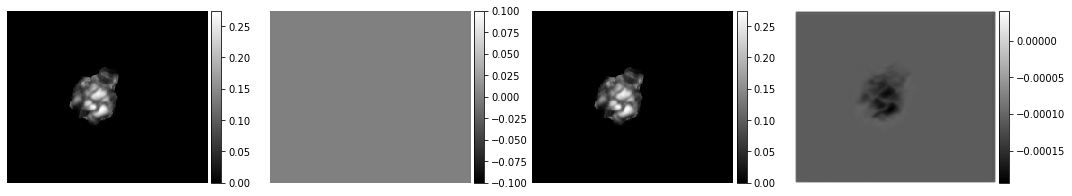

In [ ]:
images = [y_true_0_updated,y_true_1_updated, y_pred_0_updated, y_pred_1_updated]

ne.plot.slices(images, cmaps=['gray'], do_colorbars=True);


In [ ]:
inshape

(160, 192, 224)

In [ ]:
# final model save
model.save(os.path.join('C:/Users/soumi/Desktop/Deep Learning/Image registration Project/Voxelmorph_erroneous/', '%04d.pt' %args.epochs))
#torch.save(model.state_dict(),'C:/Users/soumi/Desktop/Deep Learning/Image registration Project/Voxelmorph_erroneous/voxelmorph_trained')

In [ ]:
#model = vxm.networks.VxmDense(inshape=inshape,nb_unet_features=[enc_nf, dec_nf],bidir=bidir,int_downsize=args.int_downsize)
model_test = vxm.networks.VxmDense.load('C:/Users/soumi/Desktop/Deep Learning/Image registration Project/Voxelmorph_erroneous/0001.pt', device)
model.to(device)
model.eval()

VxmDense(
  (unet_model): Unet(
    (upsample): Upsample(scale_factor=2.0, mode=nearest)
    (downarm): ModuleList(
      (0): ConvBlock(
        (main): Conv3d(2, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): ConvBlock(
        (main): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (2): ConvBlock(
        (main): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (3): ConvBlock(
        (main): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
    )
    (uparm): ModuleList(
      (0): ConvBlock(
        (main): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (activation): LeakyReLU(negative_slope=0.

In [ ]:
moving = vxm.py.utils.load_volfile('C:/Users/soumi/Desktop/Deep Learning/Image registration Project/Voxelmorph_erroneous/seg.npy', add_batch_axis=True, add_feat_axis=add_feat_axis)
fixed, fixed_affine = vxm.py.utils.load_volfile(
    'C:/Users/soumi/Desktop/Deep Learning/Image registration Project/Voxelmorph_erroneous/vol.npy', add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)


In [ ]:
input_moving = torch.from_numpy(moving).to(device).float().permute(0, 4, 1, 2, 3)
input_fixed = torch.from_numpy(fixed).to(device).float().permute(0, 4, 1, 2, 3)

In [ ]:
moved, warp = model(input_moving, input_fixed, registration=True)

In [ ]:
moved = moved.detach().cpu().numpy().squeeze()
warp = warp.detach().cpu().numpy().squeeze()

In [ ]:
print(moving.shape,fixed.shape,moved.shape,warp.shape)
moving_updated = moving[0,:,:,:,0]
fixed_updated = fixed[0,:,:,:,0]
moved_updated = moved[:,:,:]
warp_updated = warp[0,:,:,:]
print(moving_updated.shape, fixed_updated.shape,moved_updated.shape,warp_updated.shape)

(1, 160, 192, 224, 1) (1, 160, 192, 224, 1) (160, 192, 224) (3, 160, 192, 224)
(160, 192, 224) (160, 192, 224) (160, 192, 224) (160, 192, 224)


In [ ]:
images = [ moving_updated[134] , fixed_updated[134] , moved_updated[134] , warp_updated[134]] 
print(len(images))

4


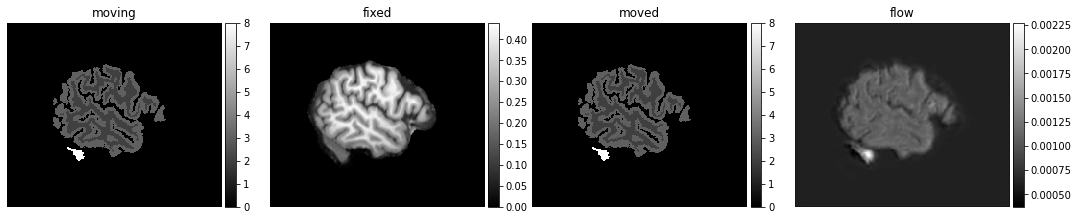

In [ ]:
#images = [img for img in moving_updated + fixed_updated + moved_updated + warp_updated] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images,titles=titles, cmaps=['gray'], do_colorbars=True);

In [ ]:
val_generator = vxm.generators.scan_to_scan(
    train_files, batch_size=args.batch_size, bidir=args.bidir, add_feat_axis=add_feat_axis)
val_input, _ = next(val_generator)

In [ ]:
print(len(val_input))
print(val_input[0].shape)

2
(1, 160, 192, 224, 1)


In [ ]:
val_pred = model_test.eval(val_input[0])

TypeError: eval() takes 1 positional argument but 2 were given

In [ ]:
print(len(y_true),y_true[0].shape)
print(len(y_pred),y_pred[0].shape)

2 torch.Size([1, 1, 160, 192, 224])
2 torch.Size([1, 1, 160, 192, 224])
